#  Evolutionary Multiple-objective Optimization (part for 4.0)

- This script is for those who want to improve their final grade from 3.0 to 4.0. 
- Your task is to implement any one evolutionary algorithm for multiple-objective optimization introduced during the lecture (NSGA/NSGA-II/NSGA-II/MOEA/D/IBEA/HypE/SPEA2). It is recommended to implement NSGA-II or MOEA/D. 
- Note that it has to be your implementation (using external libraries is forbidden).
- The problem to be solved is the portfolio optimization tackled during lab 1.
- You can use the same data and price predictions as you made for lab 1 (Bundle1.zip) or update them accordingly to the next stage if you participate in the portfolio game (it is up to you).
- Apart from the two-objective scenario, consider also the three-objective one. As for the third objective, think about some reasonable risk-measure. You can maximize the number of non-zero weights, which should refer to minimizing risk by diversifying investments.
- Perform experimental evaluation of your implementation. You can use, e.g., the IDG or the HV metric to quantify the quality of populations constructed by the method.
- The experimental evaluation should be "reasonably extensive." E.g., run your method multiple times and average the results, show average convergence plots, do the sensitivity analysis (just four combinations of population size/generations will be enough), and depict some final populations. Also, compare the populations (only for 2D scenarios) with those generated by the ECM or WSM algorithm. Note that ECM and WSM already generate Pareto optimal solutions, so these can be considered good benchmarks for comparison.
- You can report your results here, i.e., in the jupyter notebook. You do not need to prepare any pdf report, etc. 

In [1]:
from typing import List

import matplotlib.pyplot as plt
import numpy as np

from helpers.helper import generate_risk_and_return_weights
from helpers.visualizer import plot_pareto_front

from warren_buffett import WarrenBuffett
import math
import os

class ScalarizingFunctionGenerator:
    def __init__(self):
        pass

    @staticmethod
    def generate_functions(num_objectives=2, n=100):
        if num_objectives == 2:
            return [ScalarizingFunction(w1, w2, 0) for w1, w2 in ScalarizingFunctionGenerator.generate_risk_and_return_weights(n)]
        elif num_objectives == 3:
            return [ScalarizingFunction(f1, f2, f3) for f1, f2, f3 in ScalarizingFunctionGenerator.generate_weights_3_objectives(n)]
        else:
            raise ValueError("Number of objectives must be 2 or 3.")

    @staticmethod
    def generate_risk_and_return_weights(n=100):
        weights = []
        for j1 in range(n):
            return_weight = 1 / n * j1
            risk_weight = 1 - return_weight
            weights.append((return_weight, risk_weight))
        return weights

    @staticmethod
    def generate_weights_3_objectives(n=100):
        weights = []
        for j1 in range(n + 1):  # Adjust range to include 0 and n
            for j2 in range(n + 1 - j1):  # Adjust range based on j1
                j3 = n - j1 - j2
                k1 = j1 / n
                k2 = j2 / n
                k3 = j3 / n
                weights.append((k1, k2, k3))
        return weights

class MetricEvaluator:
    def __init__(self, reference_pareto, generations_interval=100):
        self.generations_interval = generations_interval
        self.reference_pareto = reference_pareto
        self.generations = []

    def add_generation(self, generation):
        self.generations.append(generation)

    def igd_for_generations_from_df(self, run_data):
        igd_data = pd.DataFrame(columns=['generation', 'igd'])
        unique_generations = run_data['generation'].unique()
        for generation_num in unique_generations:
            generation_data = run_data[run_data['generation'] == generation_num]

            profits = generation_data['profit']
            risks = generation_data['risk']

            pareto_front = [(p, r) for p, r in zip(profits, risks)]
            igd_value = self.inverted_generational_distance(pareto_front)
            igd_data = pd.concat([igd_data, pd.DataFrame({'generation': [generation_num], 'igd': [igd_value]})], ignore_index=True)
        return igd_data

    def igd_for_generations(self):
        igd_values = {}
        for generation in self.generations:
            generation_num = generation[0]
            profits = generation[2]
            risks = generation[3]

            pareto_front = [(p, r) for p, r in zip(profits, risks)]
            igd_values[generation[0]] = self.inverted_generational_distance(pareto_front)
        return igd_values

    def inverted_generational_distance(self, pareto):
        reference_pareto = self.__normalize_pareto(self.reference_pareto)
        pareto = self.__normalize_pareto(pareto)

        total_distance = 0.0
        for s in reference_pareto:
            nearest_neighbor_distance = min(self.__euclidean_distance(s, p) for p in pareto)**2
            total_distance += nearest_neighbor_distance

        igd = math.sqrt(total_distance) / len(reference_pareto)
        return igd

    def __normalize_pareto(self, pareto):
        max_values = [max(pareto, key=lambda x: x[i])[i] for i in range(len(pareto[0]))]
        # Normalize each value in each tuple
        return [[x / max_values[i] for i, x in enumerate(point)] for point in pareto]

    def __euclidean_distance(self, point1, point2):
        return math.sqrt(sum((x - y) ** 2 for x, y in zip(point1, point2)))

    @staticmethod
    def calculate_hv(population, pareto_front):
        return 0


class HistoryWriter:
    def __init__(self, directory):
        self.directory = directory

    def dump(self, metric_evaluator: MetricEvaluator, run_id):
        for generation in metric_evaluator.generations:
            directory_path = f"{self.directory}/run_{run_id}"
            if not os.path.exists(directory_path):
                os.makedirs(directory_path)

            with open(f"{directory_path}/generation_{generation[0]}.csv", 'w') as f:
                f.write("profit, risk\n")

                incumbents = generation[1]
                profits = generation[2]
                risks = generation[3]
                for incumbent, profit, risk in zip(incumbents, profits, risks):
                    f.write("{}, {}\n".format(profit, risk))


class Instance:
    def __init__(self, cov_matrix, predictions):
        self.cov_matrix = cov_matrix
        self.predictions = predictions
        self.assets_number = len(predictions)

    def normalize(self):
        predictions_min = self.predictions.min()
        predictions_max = self.predictions.max()
        predictions = (self.predictions - predictions_min) / (predictions_max - predictions_min)

        cov_matrix_min = self.cov_matrix.min()
        cov_matrix_max = self.cov_matrix.max()
        cov_matrix = (self.cov_matrix - cov_matrix_min) / (cov_matrix_max - cov_matrix_min)

        return Instance(cov_matrix, predictions)


class ScalarizingFunction:
    def __init__(self, risk_factor, profit_factor, diversification_factor=0.0):
        self.risk_factor = risk_factor
        self.profit_factor = profit_factor
        self.diversification_factor = diversification_factor

    def __call__(self, individual, instance: Instance):
        return self.profit_factor * instance.predictions.dot(individual) - self.risk_factor * individual.dot(
            instance.cov_matrix).dot(individual) - self.diversification_factor * np.sum(np.where(individual < 1e-3, 1, 0))

    def __eq__(self, other):
        if isinstance(other, ScalarizingFunction):
            return (self.risk_factor, self.profit_factor, self.diversification_factor) == (other.risk_factor, other.profit_factor, self.diversification_factor)
        return False

    def __hash__(self):
        return hash((self.risk_factor, self.profit_factor, self.diversification_factor))


# class Individual:
#     def __init__(self, weights):
#         self.weights = weights


class MOEADAlgorithm:
    def __init__(self, instance: Instance, scalarizing_functions: List[ScalarizingFunction], **kwargs):
        self.original_instance = instance
        self.instance = instance.normalize()

        self.population_size = kwargs.get('population_size', 100)
        self.generations = kwargs.get('generations', 10000)
        self.neighborhood_size = kwargs.get('neighborhood_size', 3)

        self.scalarizing_functions = scalarizing_functions
        self.function_to_incumbents = {}
        self.population = []

    def run(self, metric_evaluator=None):
        # self.__generate_scalarizing_functions(self.scalarizing_functions_number)
        self.population = self.__initialize_population(len(self.scalarizing_functions))
        self.__random_assignment()
        for i in range(1, self.generations + 1):
            if metric_evaluator is not None and i % metric_evaluator.generations_interval == 0:
                metric_evaluator.add_generation(
                    (
                        i,
                        list(self.function_to_incumbents.values()),
                        [calculate_returns(incumbent, self.original_instance.predictions) for incumbent in list(self.function_to_incumbents.values())],
                        [calculate_risk(incumbent, self.original_instance.cov_matrix) for incumbent in list(self.function_to_incumbents.values())]
                    )
                )
            self.__evolve_population()

        return list(self.function_to_incumbents.values())

    def __generate_scalarizing_functions(self, n):
        profit_risk_factors = generate_risk_and_return_weights(n)
        for profit_factor, risk_factor in profit_risk_factors:
            self.scalarizing_functions.append(ScalarizingFunction(risk_factor, profit_factor))

    def __initialize_population(self, n):
        return np.array([self._generate_random_individual() for _ in range(n)])

    def _generate_random_individual(self):
        individual = np.random.rand(self.instance.assets_number)
        return individual / np.sum(individual)
        # return Individual(np.random.rand(self.instance.assets_number))

    def __random_assignment(self):
        for scalarizing_function in self.scalarizing_functions:
            idx = np.random.choice(len(self.population), replace=False)
            self.function_to_incumbents[scalarizing_function] = self.population[idx]

    def __evolve_population(self):
        scalarizing_function = list(self.function_to_incumbents.keys())
        np.random.shuffle(scalarizing_function)

        for scalarizing_function in self.scalarizing_functions:
            mating_pool = self.__create_mating_pool(scalarizing_function)
            parents = self.__select_parents(mating_pool)
            child = self.__crossover(parents)
            if scalarizing_function(child, self.instance) > scalarizing_function(
                    self.function_to_incumbents[scalarizing_function], self.instance):
                self.function_to_incumbents[scalarizing_function] = child
            # self.__update_incumbents(child, scalarizing_function, mating_pool)

    def __create_mating_pool(self, scalarizing_function):
        profit_factor, risk_factor = scalarizing_function.profit_factor, scalarizing_function.risk_factor
        most_similar_functions = sorted(self.scalarizing_functions,
                                        key=lambda f: abs(f.profit_factor - profit_factor) + abs(
                                            f.risk_factor - risk_factor))[:self.neighborhood_size]
        return [(f, self.function_to_incumbents[f]) for f in most_similar_functions]

    def __select_parents(self, mating_pool):
        np.random.shuffle(mating_pool)
        return mating_pool[:2]

    def __crossover(self, parents):
        parent1, parent2 = [parent[1] for parent in parents]
        crossover_point = np.random.randint(0, self.instance.assets_number)
        child = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
        child /= np.sum(child)
        return child

    def __update_incumbents(self, child, child_function, mating_pool):
        for function, incumbent in mating_pool:
            if child_function(child, self.instance) > function(incumbent, self.instance):
                self.function_to_incumbents[function] = child


def calculate_risk(weights, cov_matrix):
    return weights.dot(cov_matrix).dot(weights)


def calculate_returns(weights, predictions):
    return predictions.dot(weights)

def create_pareto_front(individuals, predictions, cov_matrix):
    pareto_front = []
    for individual in individuals:
        risk = calculate_risk(individual, cov_matrix)
        profit = calculate_returns(individual, predictions)
        if np.sum(individual) > 1.0 + 1e-6:
            raise ValueError("Invalid weights")
        pareto_front.append((individual, profit, risk))
        pareto_front.sort(key=lambda x: x[1])
    return pareto_front

In [2]:
import seaborn as sns

def plot_pareto_fronts(pareto_fronts, linear_front_index=None):
    plt.figure(figsize=(8, 6))
    # Define a color palette for seaborn
    palette = sns.color_palette("husl", len(pareto_fronts))
    for i, pareto_front in enumerate(pareto_fronts):
        profits = [point[0] for point in pareto_front]
        risks = [point[1] for point in pareto_front]
        if i == linear_front_index:
            sns.scatterplot(x=profits, y=risks, label=f'Pareto Front {i+1}', marker='o', color=palette[i])
        else:
            if i == 1:  # Increase marker size for Pareto front 2
                sns.scatterplot(x=profits, y=risks, label=f'Pareto Front {i+1}', color=palette[i], s=100)
            else:
                sns.scatterplot(x=profits, y=risks, label=f'Pareto Front {i+1}', color=palette[i], s=50)
    plt.xlabel('Profit')
    plt.ylabel('Risk')
    plt.title('Pareto Fronts')
    plt.legend()
    plt.show()

In [3]:
def save_pareto_front(pareto_front, filename):
    with open(filename, 'w') as f:
        f.write(', '.join(["weight_{i}".format(i=i) for i in range(len(pareto_front[0][0]))]) + ", profit, risk\n")
        for individual in pareto_front:
            f.write(', '.join(str(weight) for weight in individual[0]) + ", {}, {}\n".format(individual[1], individual[2]))

def plot_igd_for_generations(igd_values):
    # Extracting generations and corresponding IGD values
    generations = list(igd_values.keys())
    igd_scores = list(igd_values.values())

    # Plotting
    plt.scatter(generations, igd_scores, marker='o', linestyle='-')
    plt.xlabel('Generation')
    plt.ylabel('Inverted Generational Distance (IGD)')
    plt.title('IGD for Generations')
    plt.grid(True)
    plt.show()


In [4]:
wb = WarrenBuffett()
wsm_pareto_front = wb.make_me_rich()

predictions = np.array(list(wb.get_expected_returns().values()))
cov_matrix = wb.get_covariance_matrix()

instance = Instance(cov_matrix, predictions)

     pcost       dcost       gap    pres   dres
 0: -8.9585e+00 -2.8874e+00  1e+02  9e+00  4e+00
 1: -5.6715e-01 -2.7771e+00  2e+00  9e-15  9e-16
 2: -1.3421e+00 -1.8963e+00  6e-01  1e-15  6e-16
 3: -1.8651e+00 -1.8921e+00  3e-02  1e-16  6e-16
 4: -1.8872e+00 -1.8875e+00  3e-04  2e-16  6e-16
 5: -1.8874e+00 -1.8874e+00  3e-06  3e-16  8e-16
 6: -1.8874e+00 -1.8874e+00  3e-08  6e-16  6e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.3588e-04 -1.0008e+00  1e+00  4e-16  5e+00
 1:  2.3531e-04 -1.0762e-02  1e-02  3e-17  5e-02
 2:  1.9837e-04 -6.7310e-04  9e-04  5e-17  4e-03
 3:  8.9830e-05 -8.3074e-05  2e-04  1e-16  1e-18
 4:  7.0147e-05  3.5737e-05  3e-05  5e-17  6e-19
 5:  6.2606e-05  5.7943e-05  5e-06  1e-16  4e-19
 6:  6.1499e-05  6.1183e-05  3e-07  5e-17  7e-19
 7:  6.1373e-05  6.1354e-05  2e-08  5e-17  9e-19
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.2544e-02 -1.0220e+00  1e+00  2e-16  5e+00
 1:  1.1914e-02 -3.0228e

In [11]:
# reference_pareto = [(p, r) for (_, p, r) in wsm_pareto_front[::]]
#
# function_numbers = [10, 50, 100, 200]
# generations = 10_000
#
# for f_num in function_numbers:
#     writer = HistoryWriter(f"history/MOEAD_{f_num}_{generations}")
#
#     for i in range(5):
#         algorithm = MOEADAlgorithm(instance, ScalarizingFunctionGenerator.generate_functions(num_objectives=2, n=f_num), population_size=f_num*5, generations=generations, neighborhood_size=3)
#         metric_evaluator = MetricEvaluator(reference_pareto, generations_interval=100)
#         individuals = algorithm.run(metric_evaluator)
#         writer.dump(metric_evaluator, i)

In [5]:
algorithm = MOEADAlgorithm(instance, ScalarizingFunctionGenerator.generate_functions(2, 100), population_size=100, generations=10_000, neighborhood_size=3)
reference_pareto = [(p, r) for (_, p, r) in wsm_pareto_front[::]]
metric_evaluator = MetricEvaluator(reference_pareto, generations_interval=100)
individuals = algorithm.run(metric_evaluator)

# igds = metric_evaluator.igd_for_generations()
# plot_igd_for_generations(igds)

In [16]:
algorithm2 = MOEADAlgorithm(instance, ScalarizingFunctionGenerator.generate_functions(2, 10), population_size=100, generations=10_000, neighborhood_size=3)
individuals2 = algorithm2.run()

In [79]:
algorithm3 = MOEADAlgorithm(instance, ScalarizingFunctionGenerator.generate_functions(2, 1_000), population_size=100, generations=1_000, neighborhood_size=3)
individuals3 = algorithm3.run()

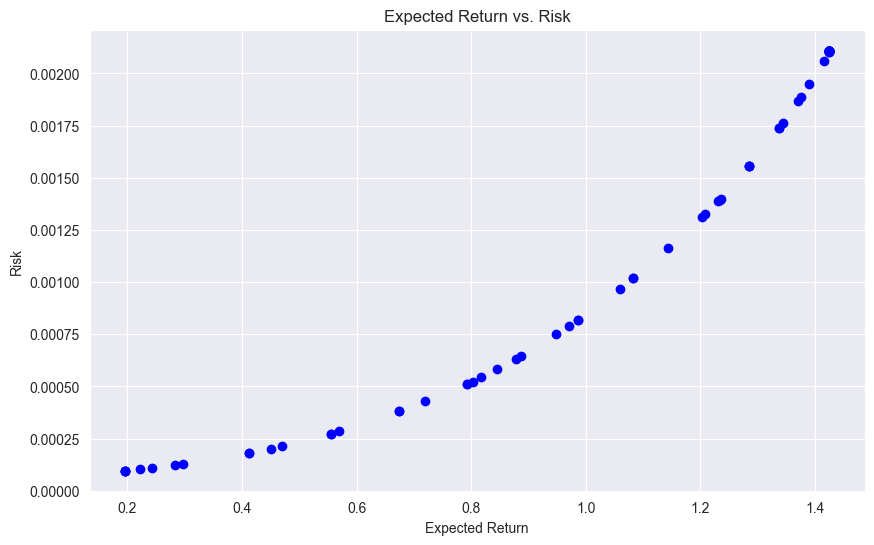

In [6]:
pareto_front1 = create_pareto_front(individuals, predictions, cov_matrix)
plot_pareto_front(pareto_front1)

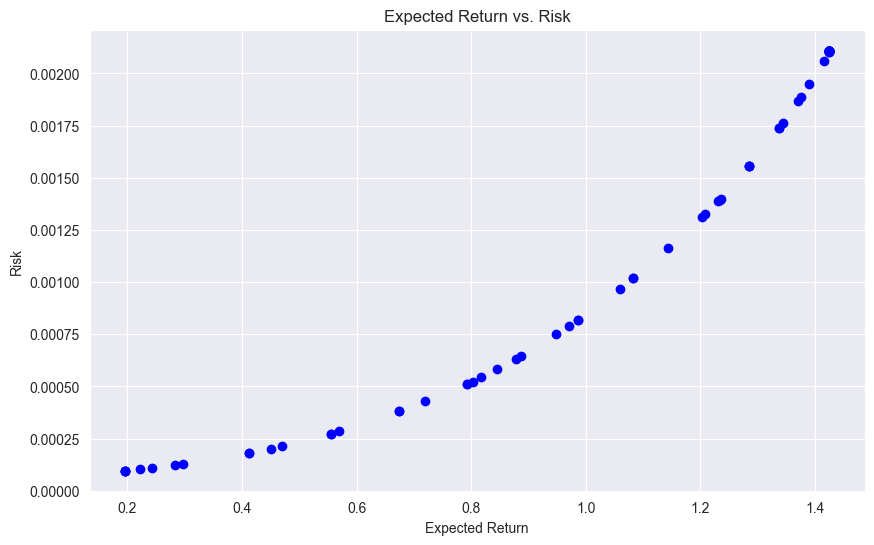

In [10]:
# len(metric_evaluator.generations[-1][1])
# metric_evaluator.generations[-1][3]
# # # len(pareto_front1)
# # # len(individuals)
# # individuals
# tmp_pareto = create_pareto_front(metric_evaluator.generations[-1][1], predictions, cov_matrix)
# plot_pareto_front(tmp_pareto)

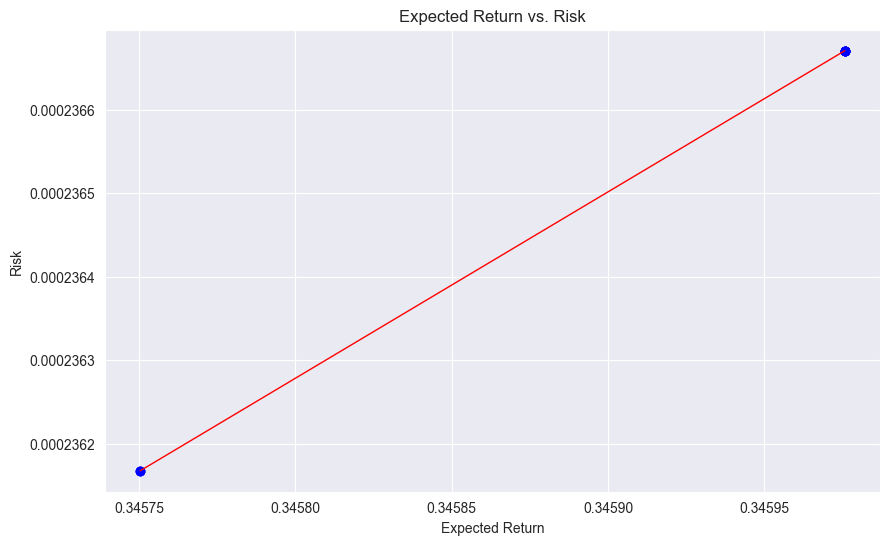

In [18]:
pareto_front2 = create_pareto_front(individuals2, predictions, cov_matrix)
plot_pareto_front(pareto_front2)

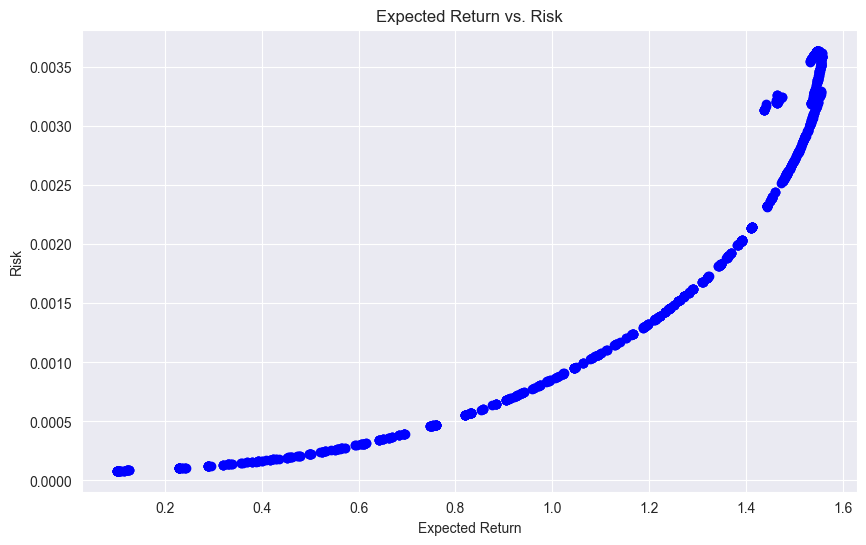

In [80]:
pareto_front3 = create_pareto_front(individuals3, predictions, cov_matrix)
plot_pareto_front(pareto_front3)

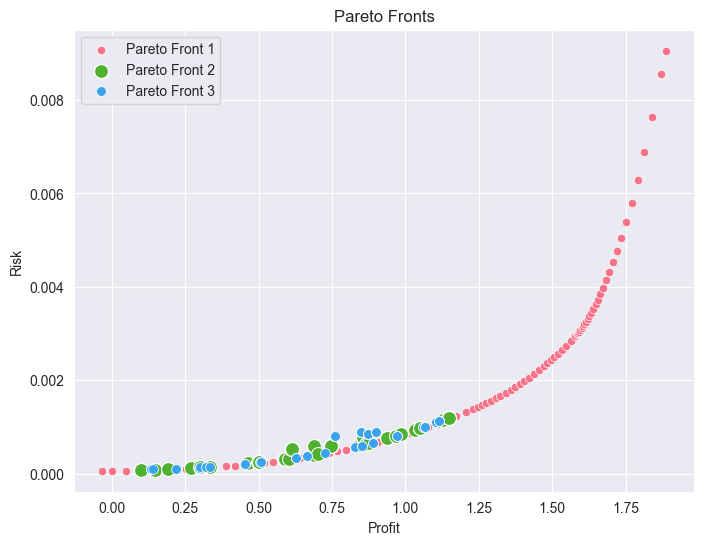

In [11]:
pareto_fronts = [[(p[0], r) for (_, p, r) in wsm_pareto_front[::]], [(p, r) for (_, p, r) in pareto_front2], [(p, r) for (_, p, r) in pareto_front1[::]]]
plot_pareto_fronts(pareto_fronts[::], linear_front_index=0)

In [13]:
import os
import pandas as pd

def read_data(directory):
    all_data = pd.DataFrame(columns=['profit', 'risk', 'generation', 'run_id'])

    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.startswith("generation_") and file.endswith(".csv"):
                file_path = os.path.join(root, file)
                generation_num = int(file.split('_')[1].split('.')[0])
                run_id = int(os.path.basename(root).split('_')[1])  # Extracting the numeric part from the directory name

                df = pd.read_csv(file_path, skiprows=1, names=['profit', 'risk'])
                df['generation'] = generation_num
                df['run_id'] = run_id
                all_data = pd.concat([all_data, df], ignore_index=True)
    return all_data

In [14]:
def plot_individuals(all_data):
    plt.figure(figsize=(10, 8))
    sc = plt.scatter(x=all_data['profit'], y=all_data['risk'], c=all_data['generation'], cmap="viridis")

    plt.colorbar(sc, label='Generation Number', ticks=all_data['generation'].unique()[::10].astype(int))

    plt.xlabel('Profit')
    plt.ylabel('Risk')
    plt.title('Individuals from all Generations of all Runs')
    plt.show()

In [15]:
def calculate_mean_igd_per_generation(all_data, reference_pareto, generations_interval=100):
    metric_evaluator = MetricEvaluator(reference_pareto, generations_interval=generations_interval)
    unique_run_ids = all_data['run_id'].unique()
    combined_igds = pd.DataFrame(columns=['generation', 'igd', 'run_id'])
    for run_id in unique_run_ids:
        run_data = all_data[all_data['run_id'] == run_id]
        igds = metric_evaluator.igd_for_generations_from_df(run_data)
        igds['run_id'] = run_id
        combined_igds = pd.concat([combined_igds, igds], ignore_index=True)

    mean_igd_per_generation = combined_igds.groupby('generation')['igd'].mean().reset_index()
    return mean_igd_per_generation

In [16]:
data_10 = read_data('history/MOEAD_10_10000')
data_100 = read_data('history/MOEAD_100_10000')
data_50 = read_data('history/MOEAD_50_10000')
data_200 = read_data('history/MOEAD_200_10000')

reference_pareto = [(p, r) for (_, p, r) in wsm_pareto_front[::]]

mean_igd_per_generation_10 = calculate_mean_igd_per_generation(data_10, reference_pareto)
mean_igd_per_generation_50 = calculate_mean_igd_per_generation(data_50, reference_pareto)
mean_igd_per_generation_100 = calculate_mean_igd_per_generation(data_100, reference_pareto)
mean_igd_per_generation_200 = calculate_mean_igd_per_generation(data_200, reference_pareto)

igd_values_dict_10 = mean_igd_per_generation_10.set_index('generation')['igd'].to_dict()
igd_values_dict_50 = mean_igd_per_generation_50.set_index('generation')['igd'].to_dict()
igd_values_dict_100 = mean_igd_per_generation_100.set_index('generation')['igd'].to_dict()
igd_values_dict_200 = mean_igd_per_generation_200.set_index('generation')['igd'].to_dict()

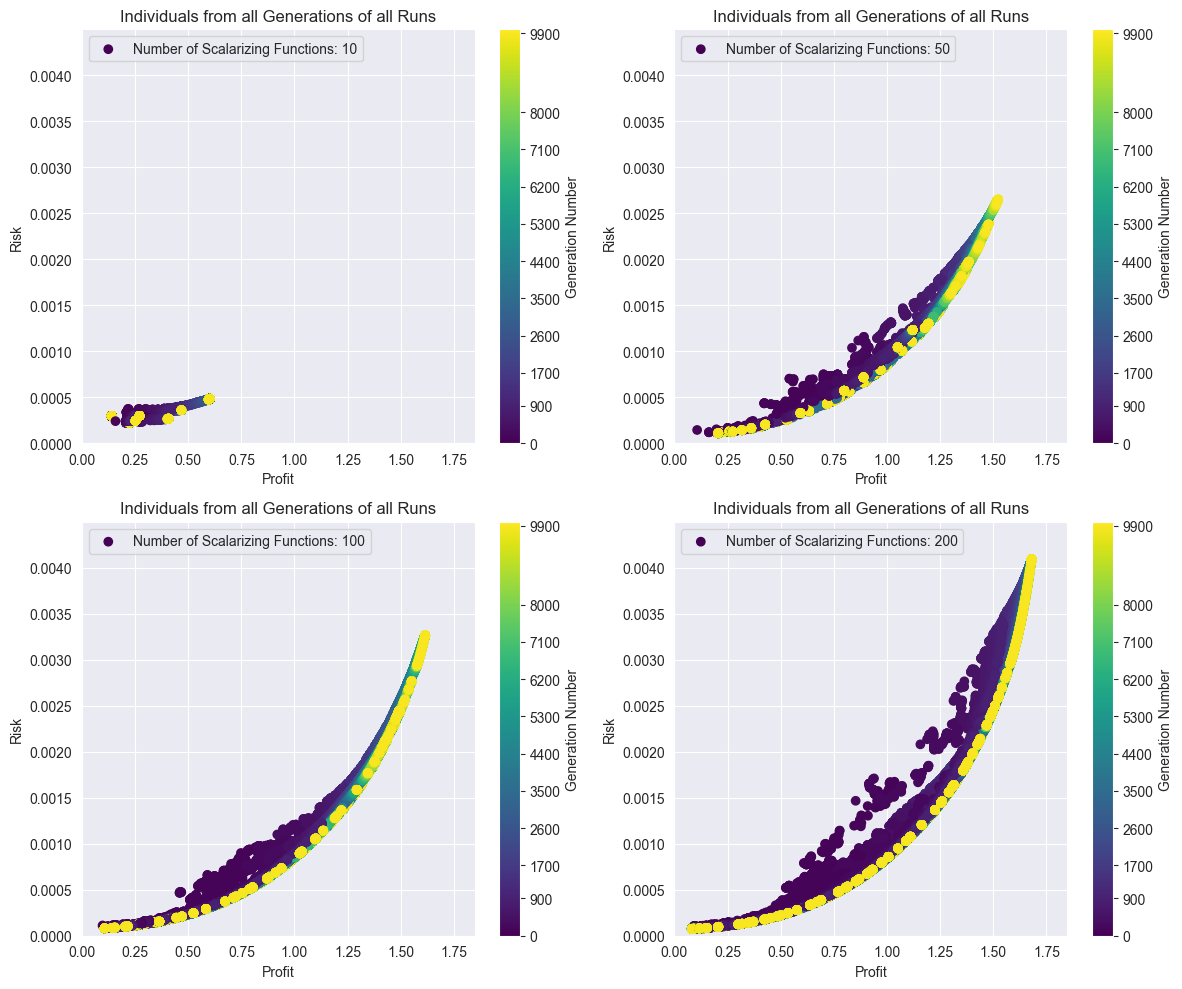

In [29]:
import matplotlib.pyplot as plt

def get_generations_plot(all_data, ax=None, num_scalar_funcs=None, ylim=None, xlim=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 4))

    if ylim is not None:
        ax.set_ylim(ylim)
    else:
        ax.set_ylim((0, all_data[all_data['risk'] < 0.1]['risk'].max() * 1.1))

    if xlim is not None:
        ax.set_xlim(xlim)

    sc = ax.scatter(x=all_data['profit'], y=all_data['risk'], c=all_data['generation'], cmap="viridis")
    cbar = plt.colorbar(sc, ax=ax, label='Generation Number', ticks=all_data['generation'].unique()[::10].astype(int))
    ax.set_xlabel('Profit')
    ax.set_ylabel('Risk')
    ax.set_title('Individuals from all Generations of all Runs')

    # Add custom legend label
    if num_scalar_funcs is not None:
        ax.legend(['Number of Scalarizing Functions: {}'.format(num_scalar_funcs)], loc='upper left')

    if ax is None:
        return fig, ax
    else:
        return ax

max_risk_10 = data_10[data_10['risk'] < 0.1]['risk'].max() * 1.1
max_risk_50 = data_50[data_50['risk'] < 0.1]['risk'].max() * 1.1
max_risk_100 = data_100[data_100['risk'] < 0.1]['risk'].max() * 1.1
max_risk_200 = data_200[data_200['risk'] < 0.1]['risk'].max() * 1.1

max_profit_10 = data_10['profit'].max() * 1.1
max_profit_50 = data_50['profit'].max() * 1.1
max_profit_100 = data_100['profit'].max() * 1.1
max_profit_200 = data_200['profit'].max() * 1.1

max_risk = max(max_risk_10, max_risk_50, max_risk_100, max_risk_200)
max_profit = max(max_profit_10, max_profit_50, max_profit_100, max_profit_200)


# Example usage:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Call plot_individuals function four times to get four plots and plot them in the grid
get_generations_plot(data_10, ax=axs[0, 0], num_scalar_funcs=10, ylim=(0, max_risk), xlim=(0, max_profit))
get_generations_plot(data_50, ax=axs[0, 1], num_scalar_funcs=50, ylim=(0, max_risk), xlim=(0, max_profit))
get_generations_plot(data_100, ax=axs[1, 0], num_scalar_funcs=100, ylim=(0, max_risk), xlim=(0, max_profit))
get_generations_plot(data_200, ax=axs[1, 1], num_scalar_funcs=200, ylim=(0, max_risk), xlim=(0, max_profit))

plt.tight_layout()
plt.show()


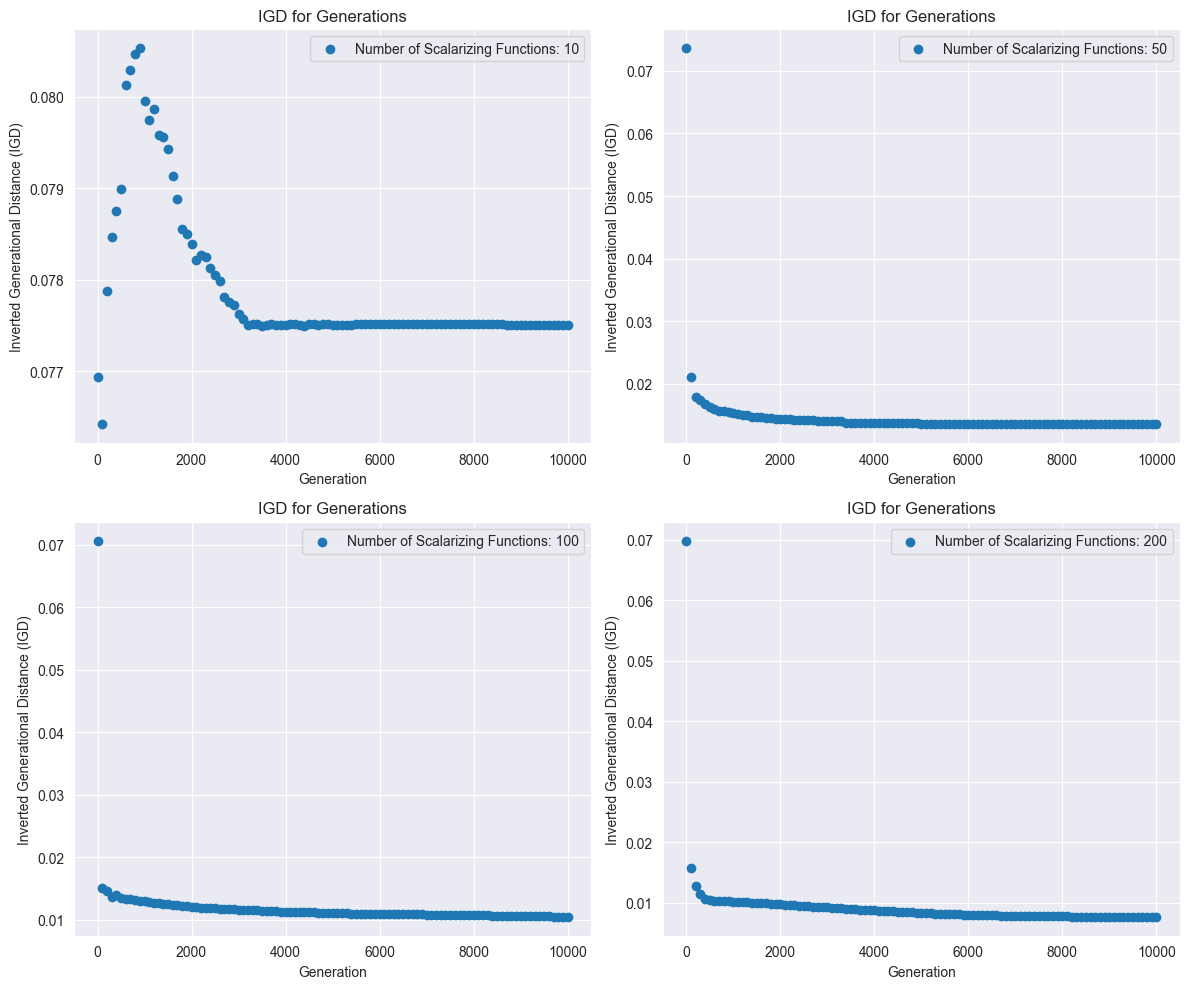

In [18]:
import matplotlib.pyplot as plt

def plot_igd_for_generations(igd_values, ax=None, num_scalar_funcs=None):
    if ax is None:
        fig, ax = plt.subplots()

    # Extracting generations and corresponding IGD values
    generations = list(igd_values.keys())
    igd_scores = list(igd_values.values())

    # Plotting
    ax.scatter(generations, igd_scores, marker='o', linestyle='-')
    ax.set_xlabel('Generation')
    ax.set_ylabel('Inverted Generational Distance (IGD)')
    ax.set_title('IGD for Generations')
    ax.grid(True)

    # Add custom legend labels for algorithm parameters
    if num_scalar_funcs is not None:
        ax.legend(['Number of Scalarizing Functions: {}'.format(num_scalar_funcs)], loc='upper right')

    if ax is None:
        return fig, ax
    else:
        return ax

# Example usage:
# Call plot_igd_for_generations function four times to get four plots and plot them in the grid
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

plot_igd_for_generations(igd_values_dict_10, ax=axs[0, 0], num_scalar_funcs=10)
plot_igd_for_generations(igd_values_dict_50, ax=axs[0, 1], num_scalar_funcs=50)
plot_igd_for_generations(igd_values_dict_100, ax=axs[1, 0], num_scalar_funcs=100)
plot_igd_for_generations(igd_values_dict_200, ax=axs[1, 1], num_scalar_funcs=200)

plt.tight_layout()
plt.show()


In [44]:
import seaborn as sns

import seaborn as sns

def get_pareto_fronts_plot(pareto_fronts, ax=None, algorithm_params=None, reference_pareto=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # Plot Pareto fronts
    palette = sns.color_palette("husl", len(pareto_fronts) + 1)
    for i, pareto_front in enumerate(pareto_fronts):
        profits = [point[0] for point in pareto_front]
        risks = [point[1] for point in pareto_front]
        ax.scatter(profits, risks, label=f'Pareto Front {i+1}', color=palette[i])

    # Plot reference Pareto front
    if reference_pareto is not None:
        ref_profits = [point[0] for point in reference_pareto]
        ref_risks = [point[1] for point in reference_pareto]
        ax.plot(ref_profits, ref_risks, label='Reference Pareto Front', color=palette[len(pareto_fronts)])

        # Add a specific legend entry for the reference Pareto front
        if algorithm_params is not None:
            ax.legend([f'{key}: {val}' for key, val in algorithm_params.items()] + ['Reference Pareto Front'], loc='upper left')
        else:
            ax.legend(['Reference Pareto Front'], loc='upper left')

    else:
        if algorithm_params is not None:
            ax.legend([f'{key}: {val}' for key, val in algorithm_params.items()], loc='upper left')
        else:
            ax.legend()

    ax.set_xlabel('Profit')
    ax.set_ylabel('Risk')
    ax.set_title('Pareto Fronts')

    if ax is None:
        return fig, ax
    else:
        return ax


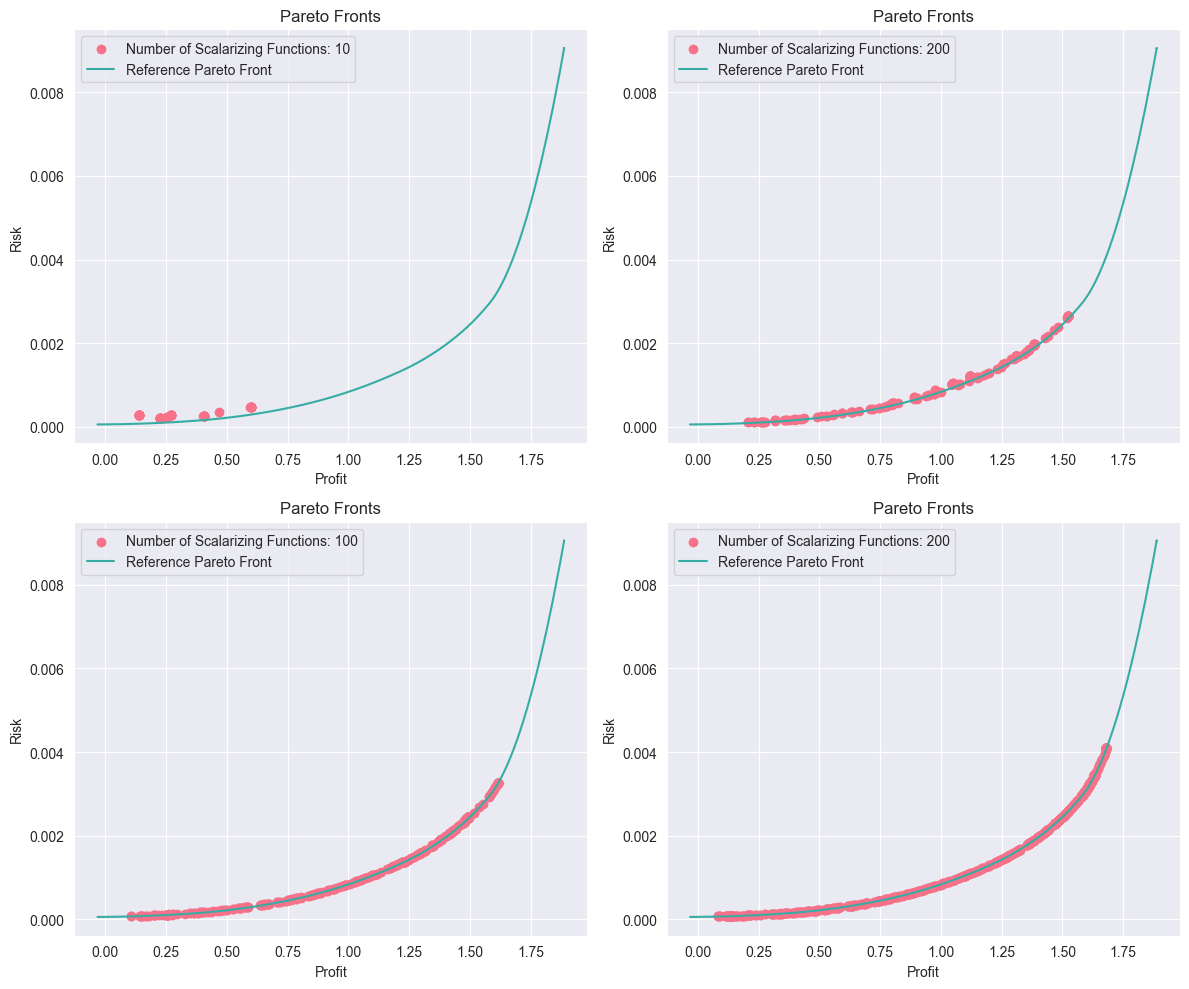

In [46]:
pareto_fronts = [
    data_10[data_10['generation'] == data_10['generation'].max()][['profit', 'risk']].apply(tuple, axis=1).tolist(),
    data_50[data_50['generation'] == data_50['generation'].max()][['profit', 'risk']].apply(tuple, axis=1).tolist(),
    data_100[data_100['generation'] == data_100['generation'].max()][['profit', 'risk']].apply(tuple, axis=1).tolist(),
    data_200[data_200['generation'] == data_200['generation'].max()][['profit', 'risk']].apply(tuple, axis=1).tolist()
]

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
get_pareto_fronts_plot(pareto_fronts[0:1], ax=axs[0, 0], algorithm_params={'Number of Scalarizing Functions': 10}, reference_pareto=reference_pareto)
get_pareto_fronts_plot(pareto_fronts[1:2], ax=axs[0, 1], algorithm_params={'Number of Scalarizing Functions': 200}, reference_pareto=reference_pareto)
get_pareto_fronts_plot(pareto_fronts[2:3], ax=axs[1, 0], algorithm_params={'Number of Scalarizing Functions': 100}, reference_pareto=reference_pareto)
get_pareto_fronts_plot(pareto_fronts[3:4], ax=axs[1, 1], algorithm_params={'Number of Scalarizing Functions': 200}, reference_pareto=reference_pareto)

plt.tight_layout()
plt.show()
